# Importing libraries

In [1]:
import sys
from tqdm import tqdm   
import numpy as np
from iminuit import Minuit
import json
import h5py as h5
from getdist import plots, MCSamples
import matplotlib as mpl
%matplotlib inline
import matplotlib.pyplot as plt
import likelihood
import data_handling
import ps_constructor
import mcmc_toolkit
out_path = '/Users/s2223060/Desktop/primordial_features/user/bump_detection_test'

# Generating the data

In [77]:
kmin = 0.02
kmax = 0.2
data_processor = data_handling.DataProcessor(kmin, kmax)

cov_fn = "/Users/s2223060/Desktop/LSS_DATA/BOSS/highz/C_997_BOSS_DR12_NGC_z3_0.001.matrix"
pk_fn = "/Users/s2223060/Desktop/LSS_DATA/BOSS/highz/ps1D_BOSS_DR12_NGC_Recon_0.5_0.75_768_0.001_0.4_3500_renorm.dat"
k,_ = data_processor.load_data_BOSS(pk_fn)
COV = data_processor.load_cov(cov_fn)

#HARTLAP CORRECTION
Nmocks = 997
Nb = len(k)
invCOV = np.linalg.inv(COV)
invCOV *= (Nmocks-Nb-2)/(Nmocks-1)

#Initialize the models
ps_filename = '/Users/s2223060/Desktop/primordial_features/cosmologies/power_spectrum/BOSS_highz_wiggly_decomp.txt'
BAO_model = ps_constructor.PowerSpectrumConstructor(k, ps_filename=ps_filename, pf_model='None', ps_style='compressed')
bump_model = ps_constructor.PowerSpectrumConstructor(k, ps_filename=ps_filename, pf_model='bump', ps_style='compressed')

In [82]:
#             B,  a0, a1,  a2,  a3,  a4, alpha, sigma_nl, sigma_s
BAO_params = [3, 0.2, -1,  1,  -1.3, 50,  0.95,   10,        5]

#              dP      N0     deltaN
bump_params = [-0.1,  15,    0.04]
PF_theta = [*BAO_params,*bump_params]

In [83]:
#Generate synthetic data and inject gaussian noiser
data_BAO_bare = BAO_model.Evaluate_bare(BAO_params)
data_PF_bare = bump_model.Evaluate_bare(PF_theta)

Text(0.5, 1.0, 'Noiseless')

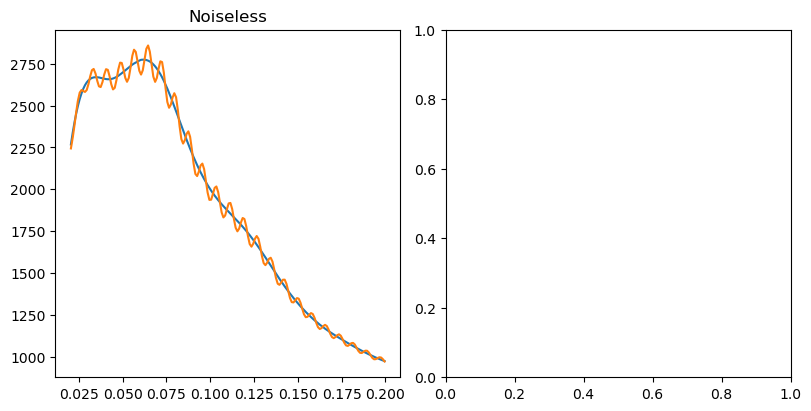

In [84]:
fig, ax = plt.subplots(1,2, figsize=(8, 4),constrained_layout=True)
ax[0].plot(k, k*data_BAO_bare)
ax[0].plot(k, k*data_PF_bare)
ax[0].set_title('Noiseless')

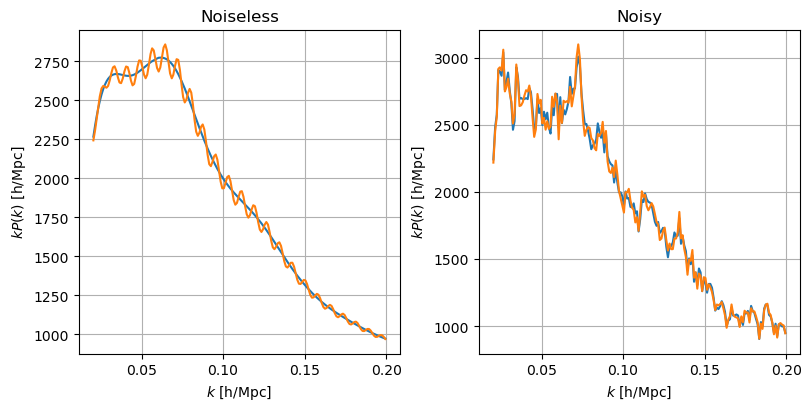

In [85]:
rng = np.random.default_rng(seed=10)
noise = 3*rng.multivariate_normal(mean=np.zeros(len(k)), cov=COV)

data_BAO = data_BAO_bare + noise
data_PF = data_PF_bare + noise

fig, ax = plt.subplots(1,2, figsize=(8, 4),constrained_layout=True)
ax[0].plot(k, k*data_BAO_bare)
ax[0].plot(k, k*data_PF_bare)
ax[0].set_title('Noiseless')

ax[1].set_title('Noisy')
ax[1].plot(k, k*data_BAO)
ax[1].plot(k, k*data_PF)

for i in range(2):
    ax[i].set_xlabel(r'$k$ [h/Mpc]')
    ax[i].set_ylabel(r'$kP(k)$ [h/Mpc]')
    ax[i].grid()

plt.savefig(out_path+'data.pdf')
np.savetxt(out_path+'/PF_params.txt', PF_theta, header='BAO_params: B, a0, a1, a2, a3, a4, alpha, sigma_nl, sigma_s\nCPSC_params: dP, N0, log10_omega_over_H')
np.savetxt(out_path+'/PF_data.txt', data_PF, header='data_BAO_bare + noise')

np.savetxt(out_path+'/BAO_params.txt', BAO_params, header='BAO_params: B, a0, a1, a2, a3, a4, alpha, sigma_nl, sigma_s')
np.savetxt(out_path+'/BAO_data.txt', data_BAO, header='data_BAO_bare + noise')

np.savetxt(out_path+'/k.txt', k, header='k [h/Mpc]')
np.savetxt(out_path+'/cov.txt', COV, header='covariance matrix')

In [86]:
#Initialize the likelihoods.
bump_fit_bump_likelihood = likelihood.likelihoods(lambda x: bump_model.Evaluate_bare(x), data_PF, invCOV)
BAO_fit_bump_likelihood = likelihood.likelihoods(lambda x: BAO_model.Evaluate_bare(x), data_PF, invCOV)
#bump_fit_BAO_likelihood = likelihood.likelihoods(lambda x: bump_model.Evaluate_bare(x), data_BAO, invCOV)
#BAO_fit_BAO_likelihood = likelihood.likelihoods(lambda x: BAO_model.Evaluate_bare(x), data_BAO, invCOV)

In [87]:
BAO_params = mcmc_toolkit.MCMC(1, 'BAO_singlepol_single_cap')
bump_mcmc = mcmc_toolkit.MCMC(1, 'bump_singlepol_single_cap')

2025-05-15 14:55:41,507 - mcmc_toolkit - INFO - Using BAO_singlepol_single_cap file
2025-05-15 14:55:41,509 - mcmc_toolkit - INFO - Input dictionary: OrderedDict([('B', [1, 8]), ('a0', [-1, 1]), ('a1', [-10, 10]), ('a2', [-50, 50]), ('a3', [-50, 50]), ('a4', [-200, 200]), ('alpha', [0.8, 1.2]), ('sigma_nl', [0, 20]), ('sigma_s', [0, 20])])
2025-05-15 14:55:41,511 - mcmc_toolkit - INFO - Expanded dictionary: OrderedDict([('B', [1, 8]), ('a0', [-1, 1]), ('a1', [-10, 10]), ('a2', [-50, 50]), ('a3', [-50, 50]), ('a4', [-200, 200]), ('alpha', [0.8, 1.2]), ('sigma_nl', [0, 20]), ('sigma_s', [0, 20])])
2025-05-15 14:55:41,516 - mcmc_toolkit - INFO - Parameter labels: ['B', 'a0', 'a1', 'a2', 'a3', 'a4', 'alpha', 'sigma_nl', 'sigma_s']
2025-05-15 14:55:41,526 - mcmc_toolkit - INFO - Parameter bounds: [[   1.    -1.   -10.   -50.   -50.  -200.     0.8    0.     0. ]
 [   8.     1.    10.    50.    50.   200.     1.2   20.    20. ]]
2025-05-15 14:55:41,733 - mcmc_toolkit - INFO - Using bump_singl

# pocoMC

In [92]:
import pocomc
from scipy.stats import uniform

In [93]:
def generate_prior(mcmc):
    loc = mcmc.prior_bounds[0]
    scale = mcmc.prior_bounds[1] - mcmc.prior_bounds[0]
    prior = pocomc.Prior([uniform(loc[i], scale[i]) for i in range(len(loc))])
    return prior

In [94]:
bao_label = 'bao_fitting_bump_noiseless'
bump_label = 'bump_fitting_bump_noiseless'

In [96]:
bump_prior = generate_prior(bump_mcmc)
BAO_prior = generate_prior(BAO_params)

In [97]:
sampler_bump = pocomc.Sampler(
    prior=bump_prior,
    likelihood=lambda x: bump_fit_bump_likelihood.logGaussian(x),
    vectorize=False,
    random_state=0,
    n_effective = 800,
    n_active = None,
    output_dir = out_path,
    output_label = bump_label,
)

In [98]:
sampler_bump.run(save_every=10)

Iter: 0it [00:00, ?it/s]

Iter: 11it [01:39, 11.82s/it, beta=0.000457, calls=21600, ESS=802, logZ=-5.32, logP=-5.3e+3, acc=0.456, steps=6, eff=1] 

Saving PMC state to /Users/s2223060/Desktop/primordial_features/user/bump_detection_test/bump_fitting_bump_noiseless_10.state


Iter: 20it [04:47, 19.49s/it, beta=0.0218, calls=52800, ESS=805, logZ=-28, logP=-864, acc=0.301, steps=9, eff=1]        

Saving PMC state to /Users/s2223060/Desktop/primordial_features/user/bump_detection_test/bump_fitting_bump_noiseless_20.state


Iter: 30it [10:25, 37.48s/it, beta=0.34, calls=95600, ESS=792, logZ=-261, logP=-742, acc=0.302, steps=6, eff=1]        

Saving PMC state to /Users/s2223060/Desktop/primordial_features/user/bump_detection_test/bump_fitting_bump_noiseless_30.state


Iter: 40it [17:26, 42.15s/it, beta=0.906, calls=149600, ESS=804, logZ=-662, logP=-723, acc=0.225, steps=60, eff=0.306]

Saving PMC state to /Users/s2223060/Desktop/primordial_features/user/bump_detection_test/bump_fitting_bump_noiseless_40.state


Iter: 48it [28:32, 76.25s/it, beta=1, calls=332896, ESS=3864, logZ=-727, logP=-715, acc=0.161, steps=60, eff=0.592]   

Saving PMC state to /Users/s2223060/Desktop/primordial_features/user/bump_detection_test/bump_fitting_bump_noiseless_final.state


Iter: 48it [28:32, 35.68s/it, beta=1, calls=332896, ESS=3864, logZ=-727, logP=-715, acc=0.161, steps=60, eff=0.592]


In [99]:
samples, weights, logl, logp = sampler_bump.posterior()

chi2 = -2*logl
chi2_min = chi2.min()
theta_ML = samples[chi2.argmin()]

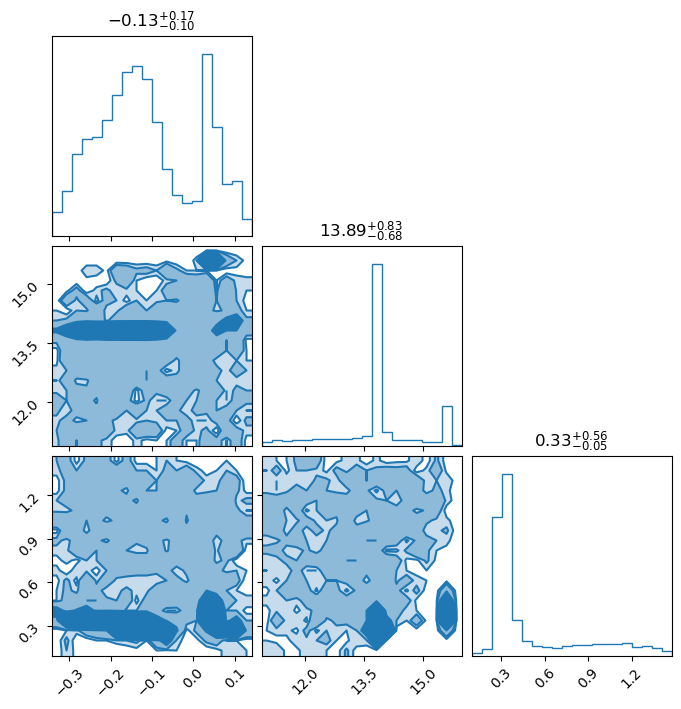

In [100]:
import corner
fig = corner.corner(samples[:, -3:], color="C0",show_titles=True, title_kwargs={"fontsize": 12}, fill_contours=True, levels=(0.68, 0.95, 0.99), plot_datapoints=False)
plt.show()

# emcee

BAO fitting BAO

In [ ]:
BAO_mcmc.set_gelman_rubin({
    "N":3,
    "epsilon":0.03,
    "min_length":5000,
    "convergence_steps":10000
})

handle_BAO = 'BAO_fitting_BAO'

def BAO_logposterior(theta):
    if not BAO_mcmc.in_prior(theta):
        return -np.inf
    else:
        return BAO_fit_BAO_likelihood.logGaussian(theta)

BAO_mcmc.set_walkers(3*BAO_mcmc.ndim)
X0 = np.array([4,  0,     0,      0,     0,    0,      1,     10,      10,    0,     0,     0.25])
DELTA = np.array([2, 0.001,   0.001, 0.001, 0.001, 0.001,  0.1,    5,       5,    0.1,    0,     0.2])

initial_positions = [BAO_mcmc.create_walkers('uniform_thin',x0=X0,delta=DELTA) for _ in range(BAO_mcmc.gelman_rubin['N'])]

BAO_mcmc.run(handle_BAO, 1, initial_positions, BAO_logposterior, gelman_rubin=True, new=True, plots=True)

In [36]:
final_chain = BAO_mcmc.get_chain(handle_BAO,gelman=BAO_mcmc.gelman_rubin)
labels_BAO = [r'B',r"a_0", r"a_1", r"a_2", r"a_3", r"a_4", r"\alpha",r"\Sigma_{\rm nl}",r"\Sigma_s"]

In [ ]:
samples_BAO = MCSamples(samples=final_chain,
                        names=labels_BAO, 
                        labels=labels_BAO,settings={'contours': [0.68, 0.95, 0.99],'smooth_scale_2D':0.05})

g1 = plots.get_single_plotter(width_inch=10)
g1.settings.title_limit = 1
g1.triangle_plot(samples_BAO,
line_args=[{'ls':'-', 'color':'C1'}],
contour_args=[{'ls':'-', 'color':'C1'}],
marker_args={'lw': 1, 'color':'black'},filled = True
)

In [44]:
theta_ML = BAO_mcmc.get_ML(handle_BAO,gelman_rubin=   BAO_mcmc.gelman_rubin)

In [45]:
bestfit = BAO_fit_BAO_likelihood.theory(theta_ML)

In [ ]:
plt.figure()
plt.plot(k,k*bestfit)
plt.plot(k,k*data_BAO)

# Ultranest

In [ ]:
import ultranest
import ultranest.stepsampler
from collections import OrderedDict
import json
import corner

In [15]:
def read_result(fn):
    chain_dir = fn+'/run1/chains/equal_weighted_post.txt'    
    results_dir = fn+'/run1/info/results.json'

    #load the final results
    with open(results_dir) as json_file:
        dic = json.load(json_file, object_pairs_hook=OrderedDict)

    #load the chain
    with open(chain_dir, 'r') as file:
        lines = file.readlines()[1:]
        chain = np.array([list(map(float, line.split())) for line in lines])
    
    bestfit = dic['maximum_likelihood']['point']
    logz = dic['logz']
    logzerr = dic['logzerr']

    return chain, bestfit, logz, logzerr

In [16]:
BAO_lo, BAO_hi = BAO_mcmc.prior_bounds[:,1:]
CPSC_lo, CPSC_hi = CPSC_mcmc.prior_bounds[:,1:]

#only use one galaxy cap
BAO_param_names = BAO_mcmc.labels[1:]
BAO_param_names[0] = 'B'
CPSC_param_names = CPSC_mcmc.labels[1:]
CPSC_param_names[0] = 'B'

In [ ]:
print('CPSC params:', CPSC_param_names)
print('BAO params:', BAO_param_names)

In [21]:
def prior_BAO(cube):
    params = cube.copy()
    params = params * (BAO_hi - BAO_lo) + BAO_lo
    return params

def prior_CPSC(cube):
    params = cube.copy()
    params = params * (CPSC_hi - CPSC_lo) + CPSC_lo
    return params

In [ ]:
BAO_prior_test = np.array([prior_BAO(np.random.rand(BAO_mcmc.ndim-1)) for i in range(10000)])
CPSC_prior_test = np.array([prior_CPSC(np.random.rand(CPSC_mcmc.ndim-1)) for i in range(10000)])

corner.corner(np.array(BAO_prior_test), titles=BAO_param_names, show_titles=True, plot_density=True, quiet=True);
corner.corner(np.array(CPSC_prior_test), titles=CPSC_param_names, show_titles=True, plot_density=True, quiet=True);
del BAO_prior_test, CPSC_prior_test

We start with the simple case: BAO fitting BAO

In [23]:
from ultranest import ReactiveNestedSampler
from ultranest.stepsampler import SliceSampler, generate_region_oriented_direction, generate_region_random_direction

In [25]:
cases = [
    [lambda x: BAO_fit_CPSC_likelihood.logGaussian(x), prior_BAO, BAO_param_names, 'user/CPSC_detection_test/BAO_fitting_BAO_vanilla'],
]

In [ ]:
cases = [
    [lambda x: CPSC_fit_CPSC_likelihood.logGaussian(x), prior_CPSC, CPSC_param_names, 'user/CPSC_detection_test/cpsc_fitting_cpsc'],
    [lambda x: BAO_fit_CPSC_likelihood.logGaussian(x), prior_BAO, BAO_param_names, 'user/CPSC_detection_test/bao_fitting_cpsc'],
]

for like, prior, params, out_dir in cases:   
    sampler = ultranest.ReactiveNestedSampler(params, like, prior,log_dir=out_dir)
    sampler.stepsampler = SliceSampler(
        nsteps=100,
        generate_direction=generate_region_random_direction,
        check_nsteps='move-distance',
        region_filter=True,
        max_nsteps=10000,
    )
    result = sampler.run(min_num_live_points=400)

In [ ]:
chain_BAO, bestfit_BAO, logz_BAO, logzerr_BAO =read_result("user/CPSC_detection_test/bao_fitting_cpsc")
chain_cpsc, bestfit_cpsc, logz_cpsc, logzerr_cpsc =read_result("user/CPSC_detection_test/cpsc_fitting_cpsc")
print('The CPSC is', np.exp(logz_cpsc-logz_BAO), 'times more likely than the BAO model')

In [48]:
from getdist import MCSamples, plots

In [67]:
labels = [r'B',r"a_0", r"a_1", r"a_2", r"a_3", r"a_4", r"\alpha",r"\Sigma_{\rm nl}",r"\Sigma_s", r"dP", r"N_* - N_0",r"\log_{10}\,\omega/H"]
labels_BAO = [r'B',r"a_0", r"a_1", r"a_2", r"a_3", r"a_4", r"\alpha",r"\Sigma_{\rm nl}",r"\Sigma_s"]

In [ ]:
samples_CPSC = MCSamples(samples=chain_cpsc,
                     names=CPSC_param_names, 
                     labels=labels,settings={'contours': [0.68, 0.95, 0.99],'smooth_scale_2D':0.05},
                     ranges = {'log10_omega_over_H':[0.1,1.9],'dP':[-0.01,0.35],'omega':[13.7,22]})

samples_BAO = MCSamples(samples=chain_BAO,
                        names=BAO_param_names, 
                        labels=labels_BAO,settings={'contours': [0.68, 0.95, 0.99],'smooth_scale_2D':0.05})

g1 = plots.get_single_plotter(width_inch=10)
g1.triangle_plot(samples_CPSC,
line_args=[{'ls':'-', 'color':'orange'}],
contour_args=[{'ls':'-', 'color':'orange'}],
marker_args={'lw': 1, 'color':'black'},filled = True,
markers={x:y for x,y in zip(CPSC_param_names,PF_theta)}
)

In [ ]:
g1 = plots.get_single_plotter(width_inch=10)
g1.triangle_plot(samples_CPSC,
line_args=[{'ls':'-', 'color':'orange'}],
contour_args=[{'ls':'-', 'color':'orange'}],
marker_args={'lw': 1, 'color':'black'},filled = True,
markers={x:y for x,y in zip(CPSC_param_names,PF_theta)}
)

In [ ]:
g1 = plots.get_single_plotter(width_inch=10)
g1.triangle_plot(samples_BAO,
line_args=[{'ls':'-', 'color':'orange'}],
contour_args=[{'ls':'-', 'color':'orange'}],
marker_args={'lw': 1, 'color':'black'},filled = True,
markers={x:y for x,y in zip(BAO_param_names,BAO_params)}
)